In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import time
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from collections import defaultdict,Counter
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [36]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [26]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [21]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_vec.get_feature_names_out())
    
    word_present = 0
    for i, v in enumerate(indices):
        if v < fea1_len:
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, f"Gene feature [{word}] present in test data point [{yes_no}]")
        elif v < fea1_len + fea2_len:
            word = var_vec.get_feature_names_out()[v - fea1_len]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, f"Variation feature [{word}] present in test data point [{yes_no}]")
        else:
            word = text_vec.get_feature_names_out()[v - (fea1_len + fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, f"Text feature [{word}] present in test data point [{yes_no}]")
    print(f"Out of the top {no_features} features, {word_present} are present in query point")
   

In [6]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [7]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55028)
(number of data points * number of features) in test data =  (665, 55028)
(number of data points * number of features) in cross validation data = (532, 55028)


In [8]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


for alpha = 1e-05
Log Loss : 1.2606139697858165
for alpha = 0.0001
Log Loss : 1.2608389203108314
for alpha = 0.001
Log Loss : 1.2580484087646095
for alpha = 0.1
Log Loss : 1.2777250700313076
for alpha = 1
Log Loss : 1.3010320154166082
for alpha = 10
Log Loss : 1.3716519658566964
for alpha = 100
Log Loss : 1.349046046246352
for alpha = 1000
Log Loss : 1.2546423287734767


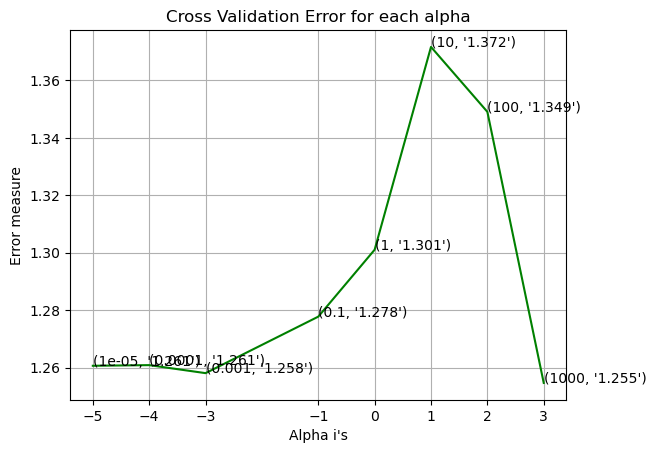

For values of best alpha =  1000 The train log loss is: 1.0320445430087954
For values of best alpha =  1000 The cross validation log loss is: 1.2546423287734767
For values of best alpha =  1000 The test log loss is: 1.3344743101049648


In [10]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))


In [15]:
# GaussianNB with response coded features and CalibratedClassifierCV

# Initialize and fit the model
clf = GaussianNB()
clf.fit(train_x_responseCoding, train_y)

# Calibrate the classifier
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

# Evaluate log loss on train, validation, and test sets
predict_y_train = sig_clf.predict_proba(train_x_responseCoding)
print("Train log loss:", log_loss(train_y, predict_y_train, labels=clf.classes_))

predict_y_cv = sig_clf.predict_proba(cv_x_responseCoding)
print("Cross validation log loss:", log_loss(cv_y, predict_y_cv, labels=clf.classes_))

predict_y_test = sig_clf.predict_proba(test_x_responseCoding)
print("Test log loss:", log_loss(test_y, predict_y_test, labels=clf.classes_))

Train log loss: 0.9103893200595001
Cross validation log loss: 1.647191609707858
Test log loss: 1.6201815875295864


In [16]:
from sklearn.naive_bayes import ComplementNB

# ComplementNB with one-hot encoded features and CalibratedClassifierCV

# Initialize and fit the model
clf = ComplementNB()
clf.fit(train_x_onehotCoding, train_y)

# Calibrate the classifier
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Evaluate log loss on train, validation, and test sets
predict_y_train = sig_clf.predict_proba(train_x_onehotCoding)
print("Train log loss:", log_loss(train_y, predict_y_train, labels=clf.classes_))

predict_y_cv = sig_clf.predict_proba(cv_x_onehotCoding)
print("Cross validation log loss:", log_loss(cv_y, predict_y_cv, labels=clf.classes_))

predict_y_test = sig_clf.predict_proba(test_x_onehotCoding)
print("Test log loss:", log_loss(test_y, predict_y_test, labels=clf.classes_))

Train log loss: 0.8485690288708083
Cross validation log loss: 1.2845682738867383
Test log loss: 1.3070970450384258


Log Loss : 1.2606139697858165
Number of missclassified point : 0.39097744360902253
-------------------- Confusion matrix --------------------


C:\Users\Aditya\AppData\Local\Temp\ipykernel_21520\2633006593.py:22: RuntimeWarning: invalid value encountered in divide
  B =(C/C.sum(axis=0))


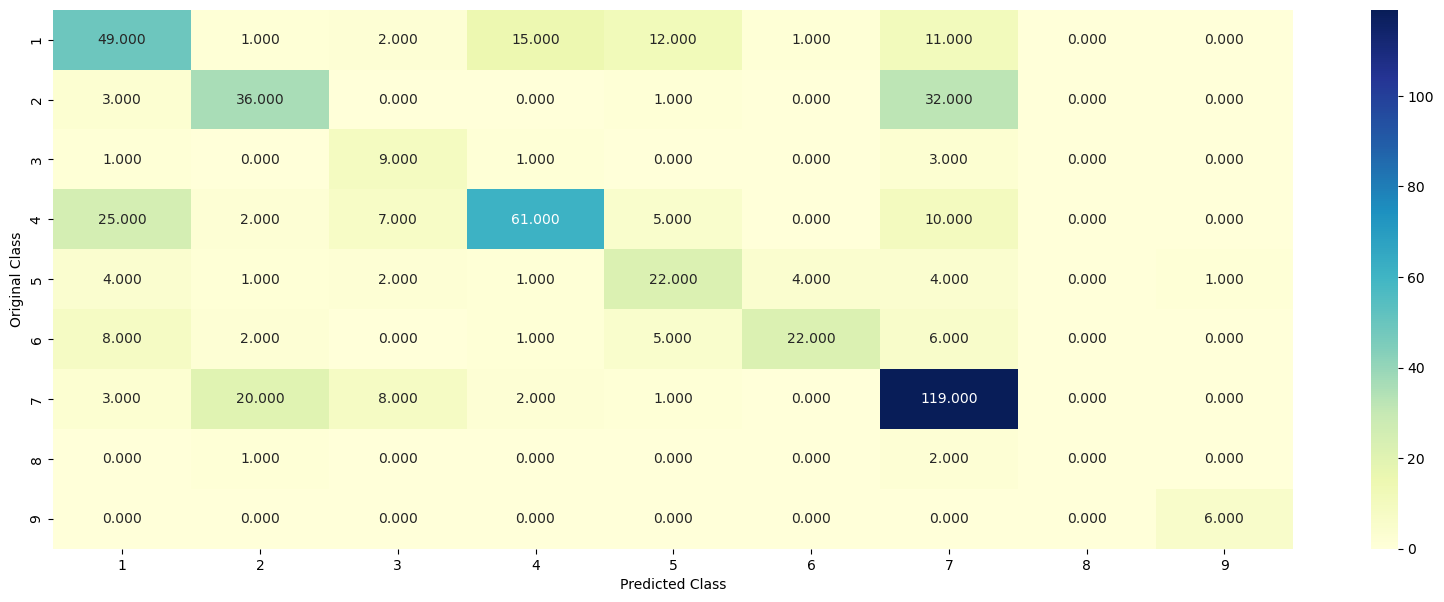

-------------------- Precision matrix (Columm Sum=1) --------------------


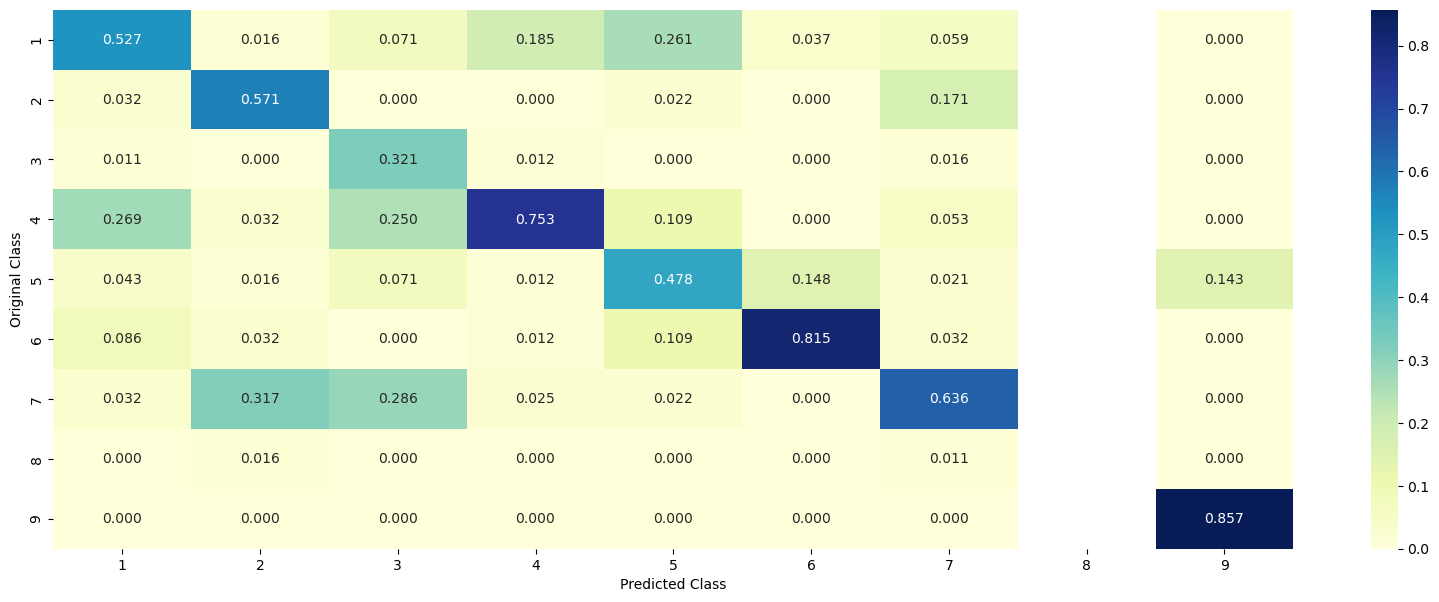

-------------------- Recall matrix (Row sum=1) --------------------


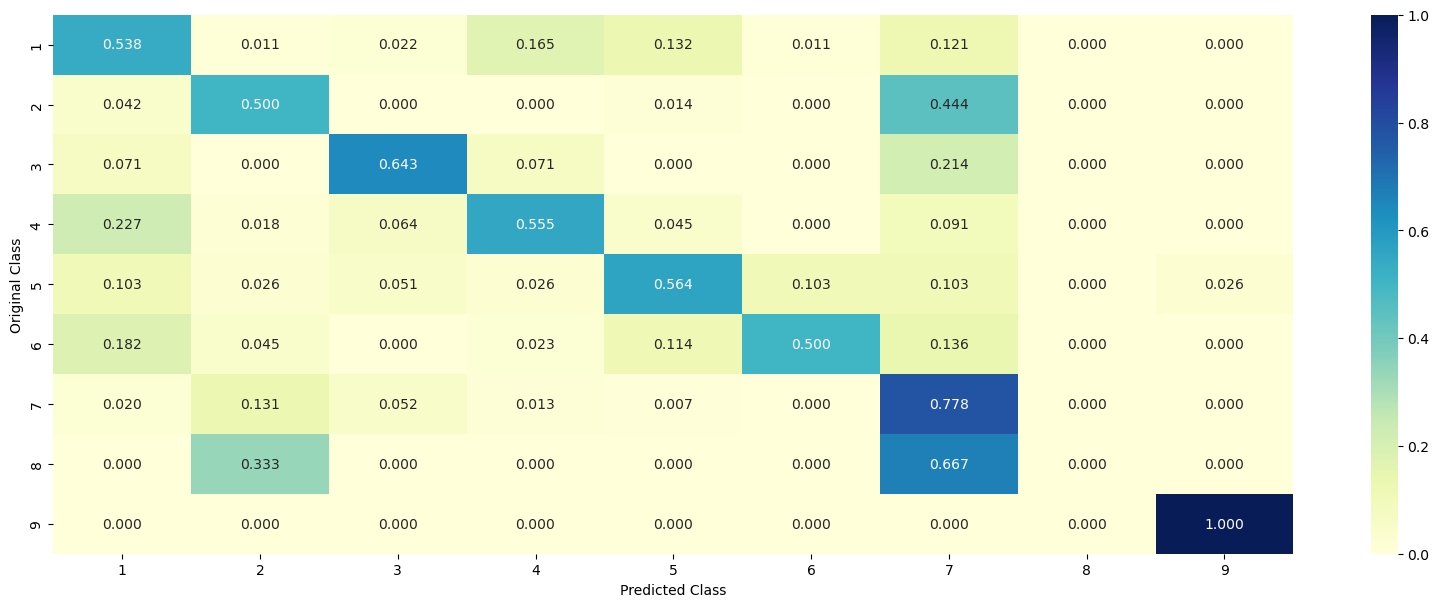

In [14]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

Log Loss : 1.2845682738867383
Number of missclassified point : 0.39097744360902253


C:\Users\Aditya\AppData\Local\Temp\ipykernel_21520\2633006593.py:22: RuntimeWarning: invalid value encountered in divide
  B =(C/C.sum(axis=0))


-------------------- Confusion matrix --------------------


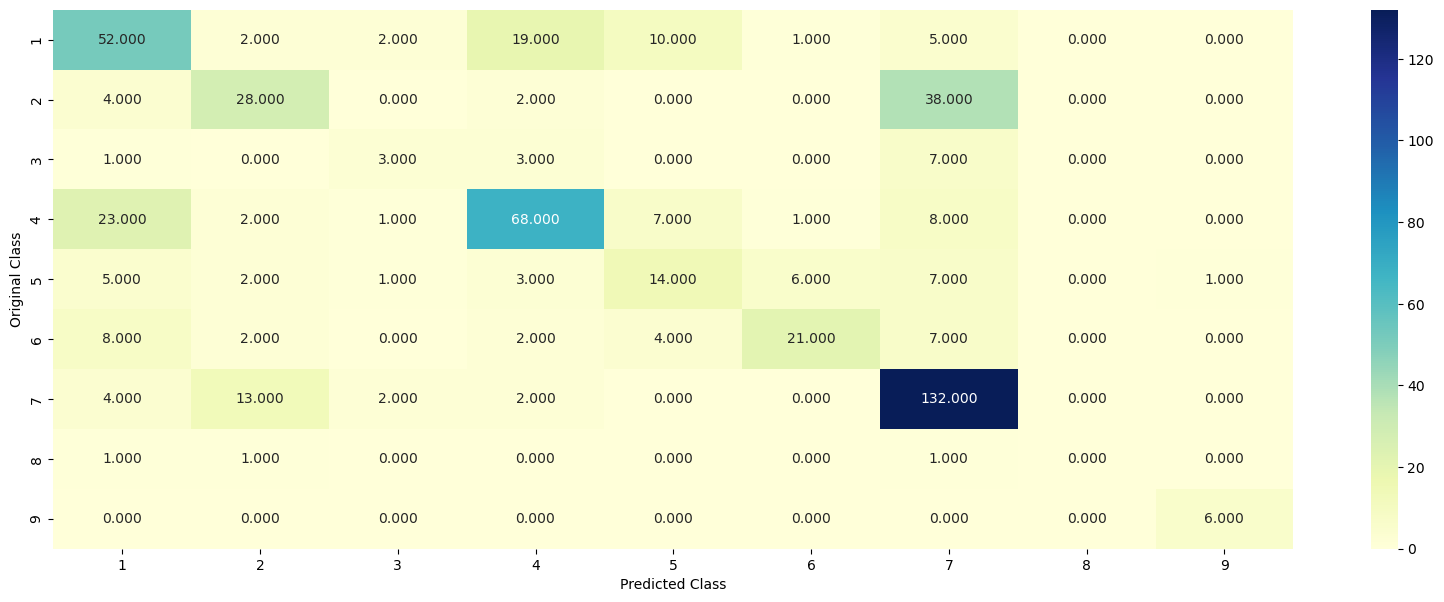

-------------------- Precision matrix (Columm Sum=1) --------------------


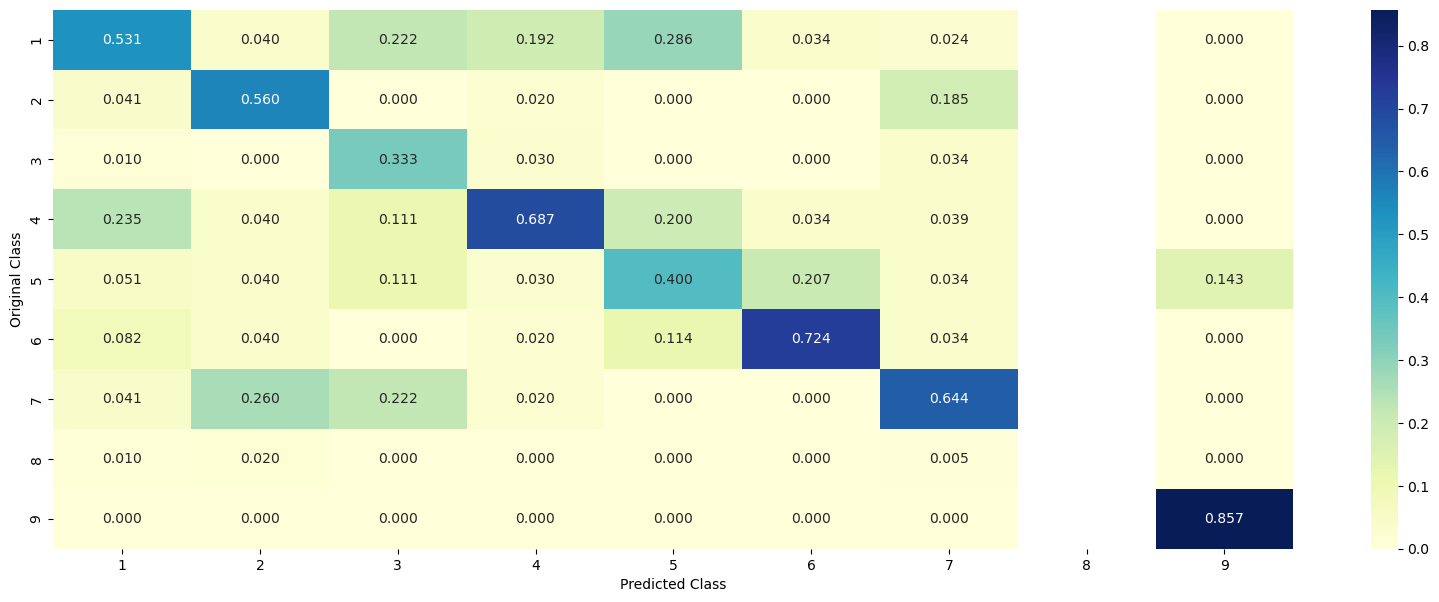

-------------------- Recall matrix (Row sum=1) --------------------


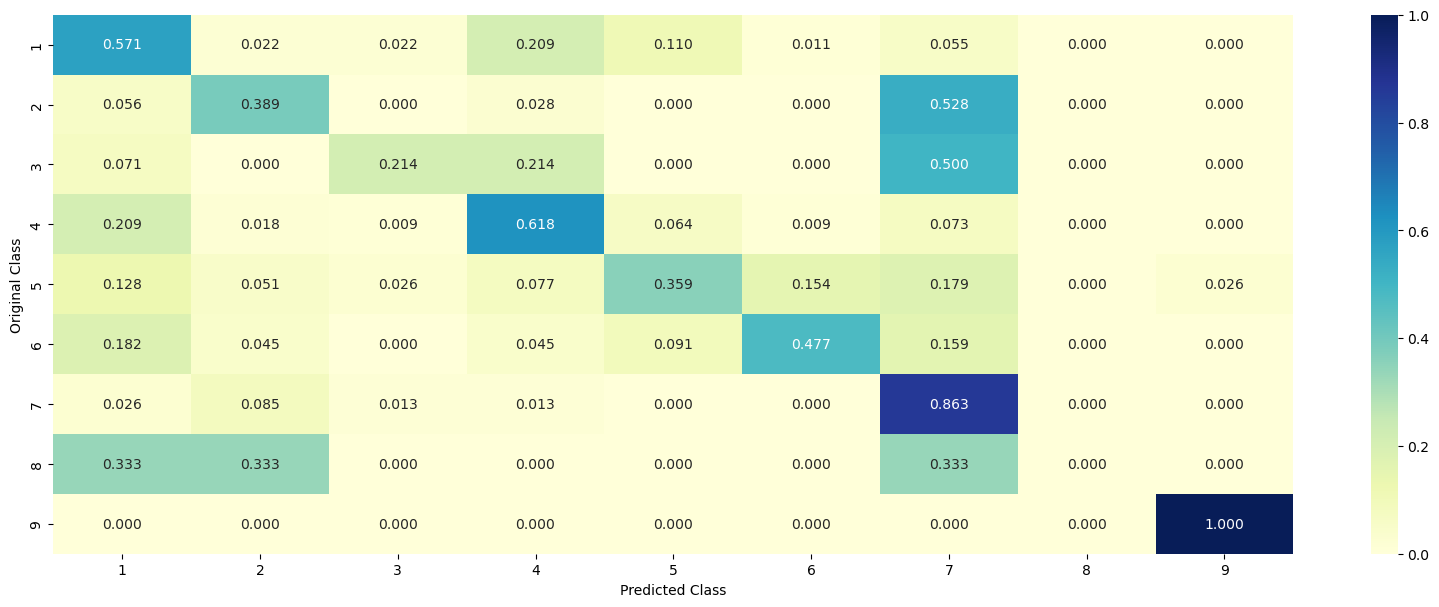

In [17]:
from sklearn.naive_bayes import ComplementNB

# Initialize ComplementNB with default parameters
clf = ComplementNB()
clf.fit(train_x_onehotCoding, train_y)

# Calibrate the classifier
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Predict probabilities for cross-validation set
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)

# Print log loss
print("Log Loss :", log_loss(cv_y, sig_clf_probs))

# Print misclassification rate
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding) - cv_y)) / cv_y.shape[0])

# Plot confusion matrix
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [34]:
test_point_index = 79
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1 * abs(clf.feature_log_prob_[predicted_cls[0]]))[:no_feature]
print("-"*50)
get_impfeature_names(
    indices,
    test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index],
    test_df['Variation'].iloc[test_point_index],
    no_feature
)

Predicted Class : 6
Predicted Class Probabilities: [[0.071  0.0834 0.018  0.3397 0.0407 0.3621 0.0763 0.0051 0.0038]]
Actual Class : 4
--------------------------------------------------
Out of the top 100 features, 0 are present in query point


In [45]:
test_point_index = 240
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]), 4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1 * abs(clf.feature_log_prob_[predicted_cls[0]]))[:no_feature]
print("-" * 50)
get_impfeature_names(
    indices,
    test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index],
    test_df['Variation'].iloc[test_point_index],
    no_feature
)

Predicted Class : 5
Predicted Class Probabilities: [[0.092  0.1093 0.0237 0.1112 0.391  0.0417 0.2195 0.0067 0.0049]]
Actual Class : 2
--------------------------------------------------
Out of the top 100 features, 0 are present in query point


In [44]:
test_point_index = 204
no_feature = 10  # Number of top features to show

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
feature_importances = clf.feature_log_prob_[predicted_cls]
top_indices = np.argsort(-feature_importances)[:no_feature]

feature_names = np.concatenate([
    CountVectorizer().fit(train_df['Gene']).get_feature_names_out(),
    CountVectorizer().fit(train_df['Variation']).get_feature_names_out(),
    CountVectorizer(min_df=3).fit(train_df['TEXT']).get_feature_names_out()
])

print(f"Test point {test_point_index} predicted class: {predicted_cls}")
print("Top contributing features:")
for idx in top_indices:
    print(f"{feature_names[idx]}: {feature_importances[idx]:.4f}")

Test point 204 predicted class: 6
Top contributing features:
maleic: 12.2456
07ee: 12.2456
5819: 12.2456
beslu: 12.2456
infinitum: 12.2456
orthodenticle: 12.2456
08548: 12.2456
0866: 12.2456
worobec: 12.2456
sphingolipid: 12.2456
